In [1]:
# Task 4: Portfolio Optimization and Backtesting

# 1. Imports and Setup
import os
import sys

# Ensure the src directory is in the Python path


sys.path.append(os.path.abspath(".."))
from pypfopt.efficient_frontier import EfficientFrontier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.portfolio_optimization import (
    calculate_portfolio_stats,
    optimize_portfolio,
    plot_efficient_frontier,
    get_portfolio_performance,
    backtest_strategy
)
from src.forecasting_analysis import generate_arima_forecast
from pmdarima.arima import ARIMA # We will re-use this for the forecast
from statsmodels.tsa.arima.model import ARIMA


In [2]:
# --- 2. Data and Forecast Loading ---
print("--- 2. Data and Forecast Loading ---")
merged_df = pd.read_csv("../data/processed/merged_prices.csv", index_col=0, parse_dates=True)
forecast_steps = 252
ticker_to_predict = 'TSLA'

# Re-train the ARIMA model to get the TSLA forecast
tsla_prices = merged_df[ticker_to_predict]
arima_model = ARIMA(tsla_prices, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))

# The fit() method returns the results object, which we'll use for forecasting.
results = arima_model.fit()

# Now pass the fitted 'results' object to your forecasting function
tsla_forecast, _ = generate_arima_forecast(results, steps=forecast_steps)
tsla_forecast_annualized_return = (tsla_forecast.iloc[-1] - tsla_forecast.iloc[0]) / tsla_forecast.iloc[0]
print("Forecasted TSLA Annualized Return:", tsla_forecast_annualized_return)

--- 2. Data and Forecast Loading ---
Generating ARIMA forecast for 252 steps...
Forecasted TSLA Annualized Return: -1.0575327256755162e-06


d:\week-11\gmf-time-series-portfolio-optimization\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\week-11\gmf-time-series-portfolio-optimization\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\week-11\gmf-time-series-portfolio-optimization\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\week-11\gmf-time-series-portfolio-optimization\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

In [3]:
# --- 3. Portfolio Statistics ---
print("\n--- 3. Calculating Portfolio Statistics ---")
# Use historical data for BND and SPY, but the forecast for TSLA
mu, sigma = calculate_portfolio_stats(merged_df, forecast_return_tsla=tsla_forecast_annualized_return)
print("Expected Returns (mu):\n", mu)
print("\nCovariance Matrix (sigma):\n", sigma)


--- 3. Calculating Portfolio Statistics ---
Expected Returns (mu):
 TSLA   -0.000001
SPY     0.142773
BND    -0.003521
dtype: float64

Covariance Matrix (sigma):
           TSLA       SPY       BND
TSLA  0.451336  0.070970  0.005029
SPY   0.070970  0.044089  0.003123
BND   0.005029  0.003123  0.004917


In [4]:
# --- 4. Portfolio Optimization ---
print("\n--- 4. Running Portfolio Optimization ---")
ef, max_sharpe_weights, max_sharpe_performance, min_vol_weights, min_vol_performance = optimize_portfolio(mu, sigma)
print("Maximum Sharpe Ratio Portfolio Weights:\n", max_sharpe_weights)
print("\nMinimum Volatility Portfolio Weights:\n", min_vol_weights)



--- 4. Running Portfolio Optimization ---
Maximum Sharpe Ratio Portfolio Weights:
 OrderedDict([('TSLA', 0.0), ('SPY', 1.0), ('BND', 0.0)])

Minimum Volatility Portfolio Weights:
 OrderedDict([('TSLA', 0.0), ('SPY', 0.04198), ('BND', 0.95802)])


d:\week-11\gmf-time-series-portfolio-optimization\venv\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(



--- 5. Plotting Efficient Frontier ---


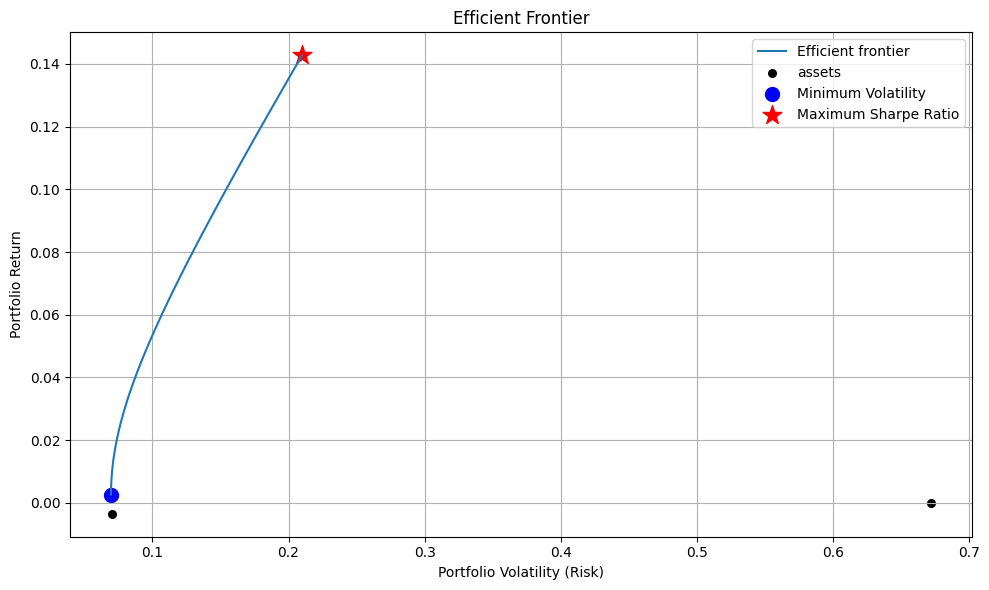

In [5]:

# --- 5. Plot Efficient Frontier ---
print("\n--- 5. Plotting Efficient Frontier ---")
# Create a fresh EfficientFrontier object for plotting
ef_for_plotting = EfficientFrontier(mu, sigma)
plot_efficient_frontier(ef_for_plotting, max_sharpe_weights, min_vol_weights, max_sharpe_performance, min_vol_performance)


In [6]:

# --- 6. Final Recommendation and Summary ---
print("\n--- 6. Final Recommendation and Summary ---")

# Let's choose the Maximum Sharpe Ratio Portfolio as the recommendation
optimal_weights = max_sharpe_weights
portfolio_return, portfolio_volatility, sharpe_ratio = max_sharpe_performance

print("### Recommended Portfolio ###")
print(f"Optimal Weights: {dict(optimal_weights)}")
print(f"Expected Annual Return: {portfolio_return:.2%}")
print(f"Annual Volatility (Risk): {portfolio_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


--- 6. Final Recommendation and Summary ---
### Recommended Portfolio ###
Optimal Weights: {'TSLA': 0.0, 'SPY': 1.0, 'BND': 0.0}
Expected Annual Return: 14.28%
Annual Volatility (Risk): 21.00%
Sharpe Ratio: 0.58



--- 7. Backtesting Your Portfolio Strategy ---

--- 1. Backtesting Strategy vs. Benchmark ---


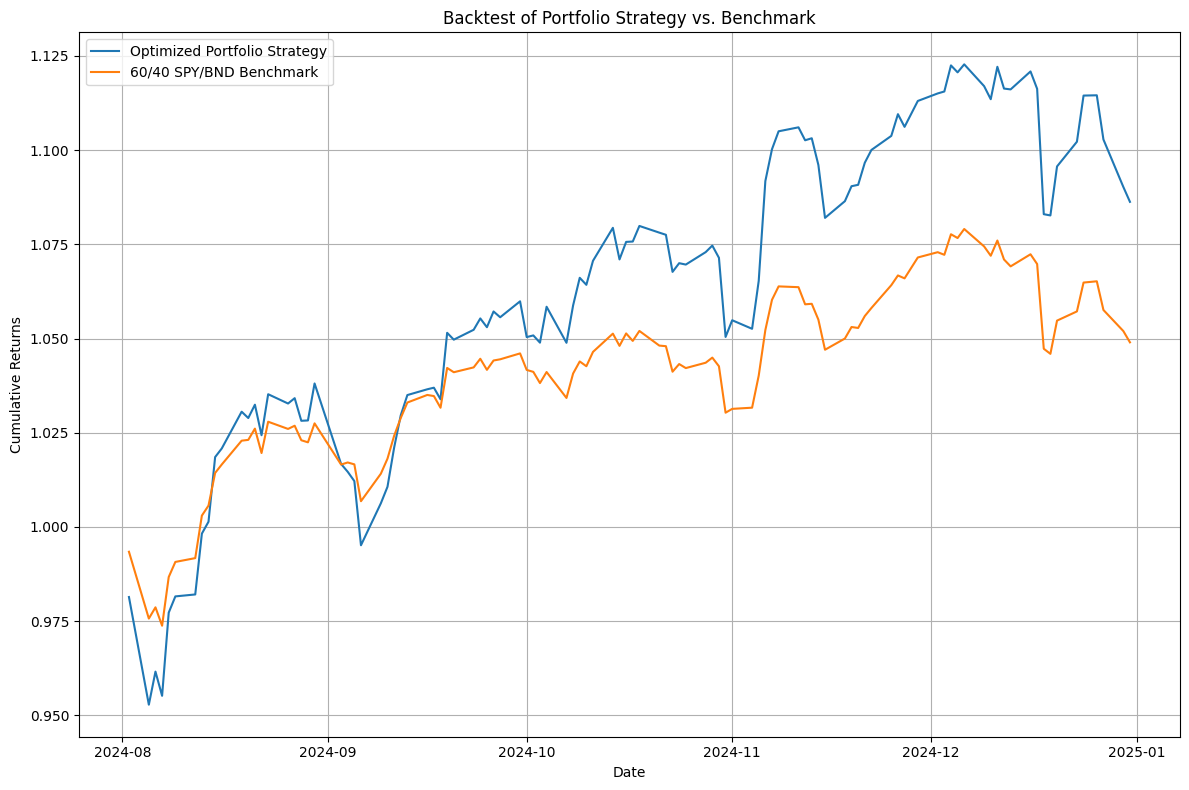


### Backtest Results ###
------------------------------
Final Performance (Backtest Period):
Strategy Total Return: 8.63%
Benchmark Total Return: 4.90%

Risk-Adjusted Performance (Annualized):
Strategy Sharpe Ratio: 1.50
Benchmark Sharpe Ratio: 1.22


In [7]:
# --- 7. Backtest the Strategy ---
print("\n--- 7. Backtesting Your Portfolio Strategy ---")

# Define the benchmark weights
benchmark_weights = {'SPY': 0.6, 'BND': 0.4, 'TSLA': 0.0} # Ensure all assets are included

# Define the backtesting period
start_date = '2024-08-01'
end_date = '2025-07-31'

# The optimal_weights from your previous step (Task 4)
optimal_weights = max_sharpe_weights

# Run the backtest using your function
backtest_strategy(merged_df, optimal_weights, benchmark_weights, start_date, end_date)
